In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import dill

from sklearn.neighbors import BallTree
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
nltk.download('wordnet')
nltk.download('punkt')
stemmer = SnowballStemmer('russian')

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans, DBSCAN

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import fowlkes_mallows_score

import seaborn as sns

from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer

from sklearn.pipeline import Pipeline 
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

[nltk_data] Downloading package wordnet to /home/pi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/pi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Preprocessing

In [2]:
data = pd.read_csv('./toxic.csv')

In [3]:
data.index

RangeIndex(start=0, stop=14441, step=1)

In [4]:
# Plotting the distribution of the labels
toxicc = 0
okc = 0
for label in data['toxic']:
    if label == 1:
        toxicc += 1
    if label == 0:
        okc += 1

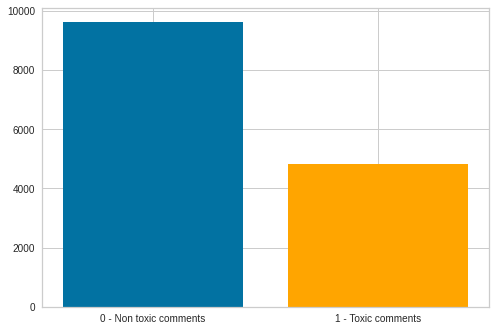

In [5]:
plt.bar('0 - Non toxic comments', okc)
plt.bar('1 - Toxic comments', toxicc, color = 'orange')
plt.show()

In [6]:
data2 = []
for i in range(0, len(data.index)):

    # Punctuation removal
    table = str.maketrans(dict.fromkeys(string.punctuation))                   
    sentences = (data.comment[i].translate(table))

    # " '\n " removal
    words = sentences[:-3] 

    # Tokenization
    words = nltk.word_tokenize(words)

    # shrt words removal & lemmatization & stemming
    words_ = []
    for word in words:
        if len(word) > 2:   
            if not word.isnumeric():                                                  
                word1 = stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v'))          
                words_.append(word1)
    data2.append(words_)

df = pd.DataFrame({'comment':data2, 'toxic':data['toxic']})
df

comment  toxic
0                               [верблюдовт, что, дебил]    1.0
1      [хохл, эт, отдушин, затюкан, россиянин, мол, в...    1.0
2                                   [собак, собач, смер]    1.0
3      [страниц, обнов, деб, эт, тож, оскорблен, дока...    1.0
4      [тиб, убед, 6страничн, пдф, том, что, скрипал,...    1.0
...                                                  ...    ...
14436                                       [приветсвош]    0.0
14437                                        [приветств]    0.0
14438                                         [как, вош]    0.0
14439                             [как, вош, мам, настр]    0.0
14440                                    [как, вош, род]    0.0

[14441 rows x 2 columns]

In [7]:
comparison = pd.DataFrame({'comments': data['comment'], 'preprocessed comments': data2, 'labels': data['toxic']})
comparison.head()

comments  \
0               Верблюдов-то за что? Дебилы, бл...\n   
1  Хохлы, это отдушина затюканого россиянина, мол...   
2                          Собаке - собачья смерть\n   
3  Страницу обнови, дебил. Это тоже не оскорблени...   
4  тибя не убедил 6-страничный пдф в том, что Скр...   

                               preprocessed comments  labels  
0                           [верблюдовт, что, дебил]     1.0  
1  [хохл, эт, отдушин, затюкан, россиянин, мол, в...     1.0  
2                               [собак, собач, смер]     1.0  
3  [страниц, обнов, деб, эт, тож, оскорблен, дока...     1.0  
4  [тиб, убед, 6страничн, пдф, том, что, скрипал,...     1.0

In [8]:
train_data__, test_data__, train_labels, test_labels = train_test_split(df['comment'], df['toxic'], test_size = 0.2, random_state = 25)

In [9]:
# CountVectorizer & TermFrequencies
cvect = CountVectorizer(ngram_range=(1, 1), lowercase='true')   
tfidf_transformer = TfidfTransformer(norm= 'l2', use_idf= True)

In [10]:
# Transforming the processed data to a list (for tfidf)
data4 = train_data__.astype(str).values.tolist()

train_data1 = cvect.fit_transform(data4)
train_data = tfidf_transformer.fit_transform(train_data1)
train_data

<11552x31677 sparse matrix of type '<class 'numpy.float64'>'
	with 213091 stored elements in Compressed Sparse Row format>

In [11]:
# Same procedure for the test data
data5 = test_data__.astype(str).values.tolist()

test_data1 = cvect.transform(data5)
test_data = tfidf_transformer.transform(test_data1)
test_data

<2889x31677 sparse matrix of type '<class 'numpy.float64'>'
	with 48379 stored elements in Compressed Sparse Row format>

In [12]:
# Same procedure for the entire data set
train_data6 = df['comment'].astype(str).values.tolist()

data1_ = cvect.fit_transform(train_data6)
data_ = tfidf_transformer.fit_transform(data1_)

### Data visualization

https://www.scikit-yb.org/en/latest/api/text/freqdist.html

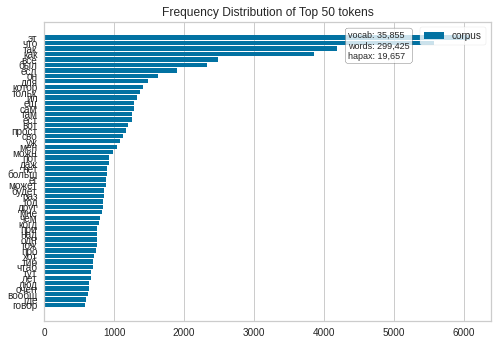

In [13]:
features = cvect.get_feature_names()

visualizer = FreqDistVisualizer(features=features)
visualizer.fit(data1_)
visualizer.poof();

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


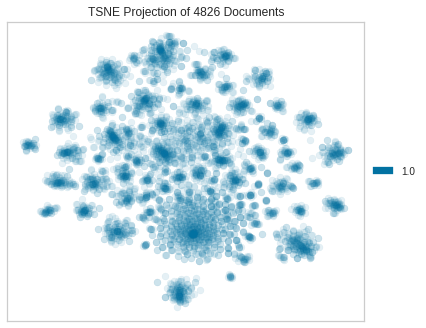

In [14]:
bb = np.where( df['toxic'] == 1)[0]
tsne = TSNEVisualizer(alpha=.1, random_state=7)
tsne.fit_transform(data_[bb], df['toxic'][bb])
tsne.show();

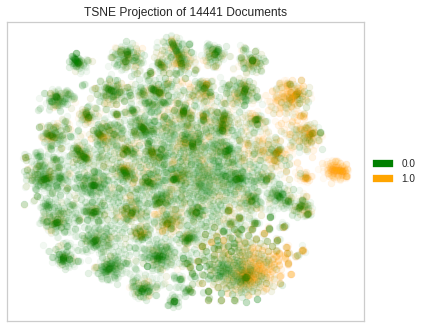

In [15]:
tsne = TSNEVisualizer(alpha=.05, colors=['green','orange'], random_state=777)
X_ = tsne.fit_transform(data_, df['toxic'])
tsne.show();

In [16]:
tsne.transformer_[0].get_params()

{'algorithm': 'randomized',
 'n_components': 50,
 'n_iter': 5,
 'random_state': 777,
 'tol': 0.0}

In [17]:
tsne.transformer_[1].get_params()

{'angle': 0.5,
 'early_exaggeration': 12.0,
 'init': 'random',
 'learning_rate': 200.0,
 'method': 'barnes_hut',
 'metric': 'euclidean',
 'min_grad_norm': 1e-07,
 'n_components': 2,
 'n_iter': 1000,
 'n_iter_without_progress': 300,
 'n_jobs': None,
 'perplexity': 30.0,
 'random_state': 777,
 'verbose': 0}

In [18]:
D = comparison
# X_.shape, data1_.shape, len(features)
D[['tsne_d1', 'tsne_d2']] = tsne.transformer_[1].embedding_

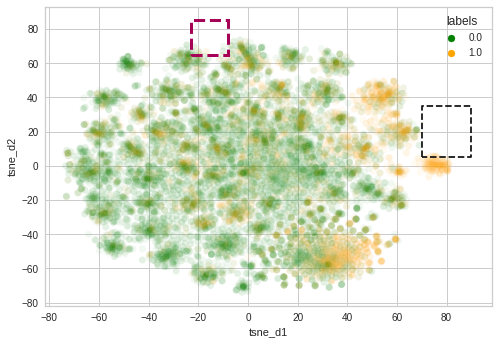

In [19]:
sns.scatterplot(x='tsne_d1', y='tsne_d2', data=D, hue='labels', alpha=.05, palette={0:'green', 1:'orange'});
plt.plot([70, 70, 90, 90, 70], [5, 35, 35, 5, 5], 'k--');
plt.gca().add_patch(plt.Rectangle((-23, 65), 15, 20, color='m', lw=3, fill=None, ls='--'));

In [20]:
D_0 = D[(D.tsne_d1>=-35) & (D.tsne_d1<-15) & (D.tsne_d2>-75) & (D.tsne_d2<-50)]
D_1 = D[(D.tsne_d1>=38) & (D.tsne_d1<50) & (D.tsne_d2>10) & (D.tsne_d2<30)]

In [21]:
print(f'\n'.join(D_0.comments))


Уроды!! у нас в семье 3 поколения там родились

59 год виходы на орбиту ви батенька, даун.

Еще у нас виявляют трещины с помощью белой краски и магнитной краски, потом прислоняют большой магнит и трещины проявляются. Не знаю как этот метод называется, у нас шви труб до 300мм им проверяют

Погуглил: В начале 90-х развитие жестких дисков ускорилось в результате бума на ПК. IBM первую гигабайтную модель HDD вивел на рынок уже в 1991 году. Это была модель 0663 Corsair 3,5-дюймовая конструкция с 8 дисками. Год спустя компания Seagate представила диск емкостью 2,1 ГБ с дисками, вращающимися со скоростью 7200 оборотов в минуту.

Вот Франция сотни десятки тисяч людей митингуют, большие потери при пресечении, а результат? Нулевой пока что. Охренненно: 7 января 2019 года на Радио классик Люк Ферри, бывший министр по делам молодежи и образавания, философ, призвал стрелять по желтим жилетам и задейсвошвать армию. Фрас суар 9.01.2019 Реакция властей: 12 февраля 2019 года премьер-министр Филипп, отв

In [22]:
print(f'\n'.join(D_1.comments))


Очевидно, что топтать дворников и чем там ещё федоровичи по всей стране занимались- это просто другой уровень деятельности Вот и попался куколд-воевака. А гонору сколько было, да мы на дунбусее, да я в грозном двери настежь - давай говно на разы. Когда вошю сестру будут насиловать черенком от веника три дворника, то ти будешь просто играть в Подземелья и Драконы и делать вид что ничего не происходит. А не, как Джимми Нейтрон напряжёшь мозги и будешь искать РЕЛЕВАНТНОЕ решение проблемы, пока сестричке, с венком ромашек на голове, раздирают дырочку. Ссали тибе в рот всем кондопогом, чека-нацианалистъ. воши маняврирования от вопросов точно такое же тухлое пиздабольсвош как и на стремах жирного, можешь в гости записатся, если достаточно всратий для их патоков. Ах, да, а хули ти у мамы под юбкой, а не спасаешь наших новиопов в трусках от злых фашистов? За пять лет так и не собрался? Давай реще, чучело.

ти лучше свои ссылки в спортлото отправляй. Там ошибок море.

Но по факту какой-то быдло

Посмотрим область в правой средней области.

In [23]:
D_ = D[(D.tsne_d1>=70) & (D.tsne_d1<90) & (D.tsne_d2>5) & (D.tsne_d2<27)]
D_

comments  \
212    Это эрефия) тут 2 метода: 1. сделать говно 2. ...   
2457                ну у хохлов еще хуже а мне-то что?\n   
2784   О! Проход в хохлы на 14 посте, что то позднова...   
5553   Егорку в детстве хохлы виебали, что он триггер...   
5622   Я еще и хохлов тут обоссываю, тоже бесплатно. ...   
5944   А ну да. Мы должны поддержать украинских шовин...   
13592           Хохлов свиньями называли ещё наши деды\n   
13668  Какую тему? То, что жиды пидорасы? По-моему эт...   
13725  Пиздец, случайно зашел в ньюс. Тут у вос какая...   
13890  Вся суть этой дерьмостраны. Ещё и тут лахтадыр...   

                                   preprocessed comments  labels    tsne_d1  \
212    [эт, эреф, тут, метод, сдела, говн, запрет, бо...     1.0  75.025467   
2457                               [хохл, ещ, хуж, мнет]     1.0  76.058205   
2784   [проход, хохл, пост, что, поздноват, проснул, ...     1.0  75.427803   
5553   [егорк, детств, хохл, виеба, что, триггер, люб...     1.0  73.711815   
5622       [ещ, хохл, тут, обоссыва, тож, бесплатн, вер]     1.0  75.371452   
5944   [должн, поддержа, украинск, шовинист, пот, что...     1.0  71.201515   
13592                      [хохл, свин, называ, ещ, наш]     1.0  76.184601   
13668  [как, тем, что, жид, пидорас, помо, эт, пришел...     1.0  73.583290   
13725  [пиздец, случайн, зашел, ньюс, тут, вос, какая...     1.0  74.850586   
13890  [вся, сут, эт, дерьмостра, ещ, тут, лахтадырк,...     1.0  74.852394   

        tsne_d2  
212    5.680735  
2457   5.354153  
2784   5.355361  
5553   5.513375  
5622   5.791352  
5944   5.526836  
13592  5.382442  
13668  5.965147  
13725  5.683481  
13890  5.614694

In [24]:
toto = []
toto.extend(D_['preprocessed comments'])

toto2 = []
[toto2.extend(_to) for _to in toto]

toto2

['эт',
 'эреф',
 'тут',
 'метод',
 'сдела',
 'говн',
 'запрет',
 'бонусн',
 'хохл',
 'ещ',
 'хохл',
 'ещ',
 'хуж',
 'мнет',
 'проход',
 'хохл',
 'пост',
 'что',
 'поздноват',
 'проснул',
 'ещ',
 'пон',
 'егорк',
 'детств',
 'хохл',
 'виеба',
 'что',
 'триггер',
 'люб',
 'укр',
 'вне',
 'зависим',
 'политическ',
 'взгляд',
 'неужт',
 'ем',
 'печет',
 'что',
 'даж',
 'юг',
 'хохлянд',
 'пынькомир',
 'посла',
 'нах',
 'ещ',
 'спал',
 'подпынек',
 'одес',
 'ещ',
 'хохл',
 'тут',
 'обоссыва',
 'тож',
 'бесплатн',
 'вер',
 'должн',
 'поддержа',
 'украинск',
 'шовинист',
 'пот',
 'что',
 'он',
 'прот',
 'путин',
 'все',
 'врем',
 'забыва',
 'передума',
 'быт',
 'хохл',
 'изз',
 'шовинизм',
 'подума',
 'три',
 'ил',
 'четир',
 'шаг',
 'вперед',
 'вот',
 'будущ',
 'национализм',
 'принадлеж',
 'ем',
 'так',
 'люд',
 'как',
 'нестер',
 'карлин',
 'про',
 'дебил',
 'вьющ',
 'вокруг',
 'мальцев',
 'больш',
 'никт',
 'вспомин',
 'хохл',
 'свин',
 'называ',
 'ещ',
 'наш',
 'как',
 'тем',
 'что',
 'ж

In [25]:
W = pd.value_counts(toto2)
W

хохл        10
ещ           9
что          7
тут          5
эт           3
            ..
пришел       1
одес         1
четир        1
пост         1
отигрыва     1
Length: 132, dtype: int64

In [26]:
W.iloc[12:32]

вос         1
зависим     1
вперед      1
вьющ        1
хуж         1
тож         1
дебил       1
ид          1
триггер     1
запрет      1
зашел       1
виеба       1
вспомин     1
даж         1
страненк    1
сут         1
сво         1
сдела       1
отсюд       1
крыш        1
dtype: int64

/home/pi/venv/venv/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FrequencyVisualizer(ax=<AxesSubplot:>,
                    features=['00х', '0252х', '068тариф', '07м', '100000км',
                              '1000из', '1000мг', '1000р', '1000рубл',
                              '1000смс', '100200р', '100300р', '100ml', '100а',
                              '100гр', '100к', '100кг', '100км', '100лет',
                              '100м', '100ма', '100мб', '100мбит', '100мг',
                              '100мм', '100р', '100смс', '100тир', '100тис',
                              '100тон', ...],
                    n=None)

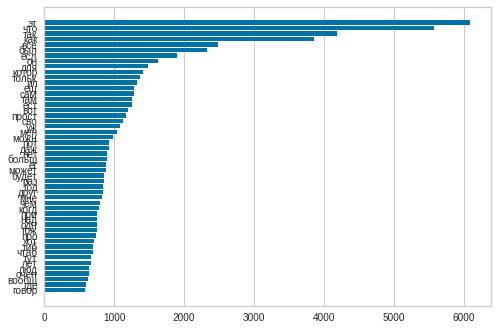

In [27]:
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(data1_)

## Supervised learning method - Naive Bayes

In [28]:
# Model fitting
model = MultinomialNB(alpha = 0.1)
model.fit(train_data, train_labels)

MultinomialNB(alpha=0.1)

In [29]:
# Prediction
prediction = model.predict(test_data)

We are using two scores to compare the results

Accuracy score = $\frac{TP + TN}{Total}$

Fowlkes Mallwows Score = $\frac{TP}{\sqrt(TP+FP)(TP+FN}$ 

In [30]:
accuracy_score(test_labels, prediction) 

0.8546209761163032

In [31]:
print(fowlkes_mallows_score(prediction, test_labels))

0.7902432956614783


In [32]:
confusion_matrix(test_labels, prediction)

array([[1834,   96],
       [ 324,  635]])

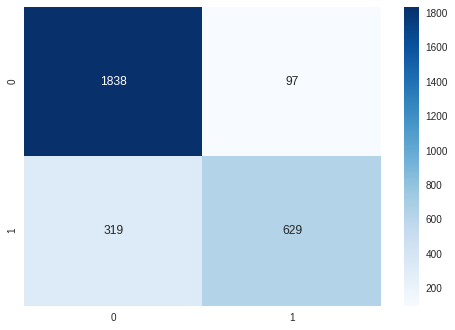

In [33]:
ax = sns.heatmap(confusion_matrix(test_labels, prediction), annot = np.array([['1838', '97'],['319', '629']]), cmap=plt.cm.Blues, fmt = '')

In [34]:
models = Pipeline([('CountVect', CountVectorizer()), 
                     ('TermFreq', TfidfTransformer()), 
                     ('NB', MultinomialNB())]) 

parameters = { 'CountVect__ngram_range': [(1, 1), (1, 2), (2, 2),(4,5)], 
              'TermFreq__use_idf': (True, False), 
              'TermFreq__norm': ('l1', 'l2'), 
              'NB__alpha': [1, 1e-1, 1e-2, 1e-3] } 

CrossValFolds = 5
grid_search= GridSearchCV(models, parameters, cv = CrossValFolds, n_jobs = -1) 
grid_search.fit(data4, train_labels)

print(grid_search.best_score_) 
print(grid_search.best_params_)

0.8669495598876817
{'CountVect__ngram_range': (1, 1), 'NB__alpha': 0.1, 'TermFreq__norm': 'l2', 'TermFreq__use_idf': True}


In [35]:
final_model = Pipeline([('CountVect', CountVectorizer(ngram_range=(1, 1))), 
                     ('TermFreq', TfidfTransformer(norm='l2', use_idf=True,)), 
                     ('NB', MultinomialNB(alpha=0.1))])
final_model.fit(train_data6, df['toxic'])

Pipeline(steps=[('CountVect', CountVectorizer()),
                ('TermFreq', TfidfTransformer()),
                ('NB', MultinomialNB(alpha=0.1))])

In [36]:
with open('toxic_pipeline.dill', 'wb') as f:
    dill.dump(final_model, f)

In [37]:
with open('toxic_pipeline.dill', 'rb') as f:
    toxic_pipeline = dill.load(f)

In [38]:
predictions = toxic_pipeline.predict_proba(train_data6)
pd.DataFrame({'predictions': predictions[:, 1]})

predictions
0         0.985865
1         0.998206
2         0.772068
3         0.942728
4         0.973639
...            ...
14436     0.086832
14437     0.022702
14438     0.611492
14439     0.261951
14440     0.500492

[14441 rows x 1 columns]

In [39]:
roc_auc_score(y_score=predictions[:, 1][:], y_true=df['toxic'])

0.9965129081748434